In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner.tuners import RandomSearch
import numpy as np
import math
import pickle

In [23]:
! pip show tensorflow
! pip install --upgrade tensorflow


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\site-packages
Requires: tensorflow-intel
Required-by: tf_keras


In [3]:
#loading the data
import pandas as pd


filepath = "C:\\Users\\Ananya\\anaconda3\\Dissertation - UL\\Music-Generation-with-AI\\Project\One_Direction_cleaned_lyrics.parquet"
lyrics_df = pd.read_parquet(filepath)


print(lyrics_df.head())


                                        Lyrics_clean
1                you're insecure don't know what for
2  you're turnin' heads when you walk through the...
3                  don't need makeup to cover up huh
4               bein' the way that you are is enough
5               everyone else in the room can see it


In [4]:
# preprocessing the data
tokenizer_lyric = Tokenizer()
tokenizer_lyric.fit_on_texts(lyrics_df['Lyrics_clean'])
sequences = tokenizer_lyric.texts_to_sequences(lyrics_df['Lyrics_clean'])
size_vocab = len(tokenizer_lyric.word_index) + 1


In [5]:
# Creating the sequences

seq_len = 10 # sequence length
input_seq = [] # input sequences
for seq in sequences:
    for i in range(seq_len, len(seq)):
        in_seq = seq[i-seq_len: i+1]
        input_seq.append(in_seq)

input_seq = pad_sequences(input_seq, maxlen=(seq_len+1), padding='pre')
X, y = input_seq[:, :-1], input_seq[:, -1]
y = to_categorical(y,num_classes=size_vocab)



In [6]:
#defining a function to create models

def create__model(embedding_dim, lstm_units, dropout_rate, learning_rate, input_length):
    #  defining the input tensor:
    inputs = Input(shape=(input_length,))
    
    # defining the Embedding layer without the input_length in the constructor:
    x = Embedding(input_dim=size_vocab, output_dim=embedding_dim)(inputs)
    
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units)(x)
    outputs = Dense(size_vocab, activation='softmax')(x)
    
    # Creating and compiling the model:
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model







In [7]:
# model creation

models = []

config_mod = [
    (50, 100, 0.1, 0.001, seq_len),
    (100, 150, 0.2, 0.001, seq_len),
    (150, 200, 0.2, 0.0001, seq_len),
    (100, 100, 0.3, 0.001, seq_len),
    (50, 200, 0.1, 0.01, seq_len)]


In [8]:
# Training and evaluating the models

results = []

hist_list = [] 

for config in config_mod:
    try:
        model = create__model(*config)
        history = model.fit(X,y, epochs= 30, batch_size = 128, validation_split= 0.2, verbose = 2)
        hist_list.append(history)
        models.append(model)
        loss, accuracy = model.evaluate(X,y, verbose=0)
        perplexity = math.exp(loss) if loss <300 else float('inf')
        results.append((model, accuracy, perplexity, loss))
    except Exception as e:
        print(f"An error occurred with configuration {config}: {e}")



Epoch 1/30
8/8 - 4s - 470ms/step - accuracy: 0.0450 - loss: 7.3646 - val_accuracy: 0.0219 - val_loss: 7.3561
Epoch 2/30
8/8 - 0s - 25ms/step - accuracy: 0.0604 - loss: 7.2746 - val_accuracy: 0.0219 - val_loss: 7.1815
Epoch 3/30
8/8 - 0s - 25ms/step - accuracy: 0.0604 - loss: 6.4456 - val_accuracy: 0.0219 - val_loss: 6.4908
Epoch 4/30
8/8 - 0s - 26ms/step - accuracy: 0.0604 - loss: 5.4368 - val_accuracy: 0.0219 - val_loss: 6.5383
Epoch 5/30
8/8 - 0s - 25ms/step - accuracy: 0.0604 - loss: 5.0958 - val_accuracy: 0.0219 - val_loss: 6.7481
Epoch 6/30
8/8 - 0s - 25ms/step - accuracy: 0.0604 - loss: 5.0659 - val_accuracy: 0.0219 - val_loss: 6.8820
Epoch 7/30
8/8 - 0s - 24ms/step - accuracy: 0.0604 - loss: 4.9907 - val_accuracy: 0.0219 - val_loss: 6.9630
Epoch 8/30
8/8 - 0s - 24ms/step - accuracy: 0.0604 - loss: 5.0083 - val_accuracy: 0.0219 - val_loss: 7.0298
Epoch 9/30
8/8 - 0s - 24ms/step - accuracy: 0.0604 - loss: 5.0283 - val_accuracy: 0.0219 - val_loss: 7.0807
Epoch 10/30
8/8 - 0s - 24ms

Model 1 - Accuracy: 0.052677787840366364, Perplexity: 250.1017292453028, Loss: 5.521867752075195
Model 2 - Accuracy: 0.052677787840366364, Perplexity: 261.1930877127918, Loss: 5.56525993347168
Model 3 - Accuracy: 0.052677787840366364, Perplexity: 221.35091192936267, Loss: 5.399749279022217
Model 4 - Accuracy: 0.052677787840366364, Perplexity: 249.59956244112442, Loss: 5.519857883453369
Model 5 - Accuracy: 0.4688323140144348, Perplexity: 37.533348664681235, Loss: 3.625229835510254


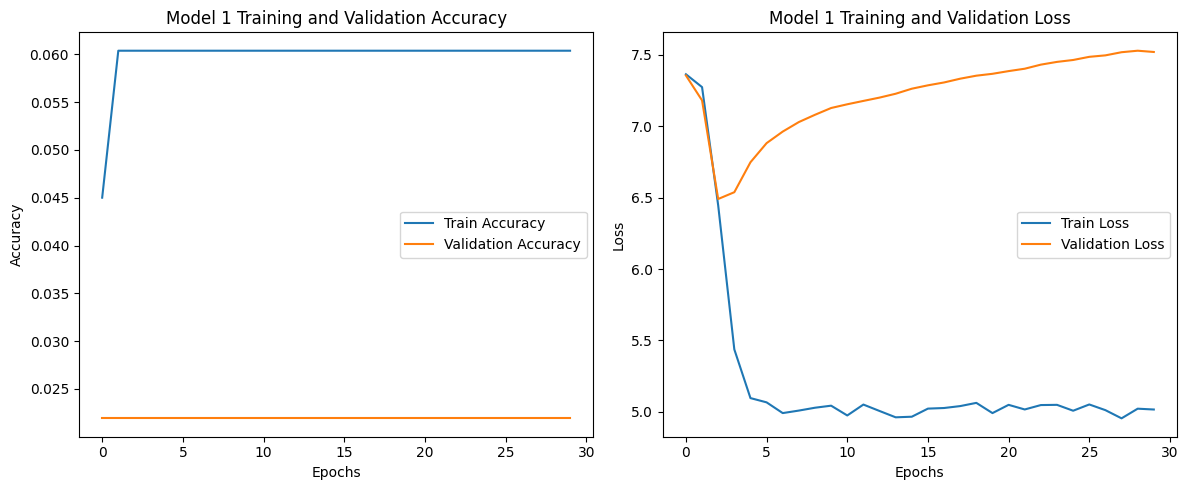

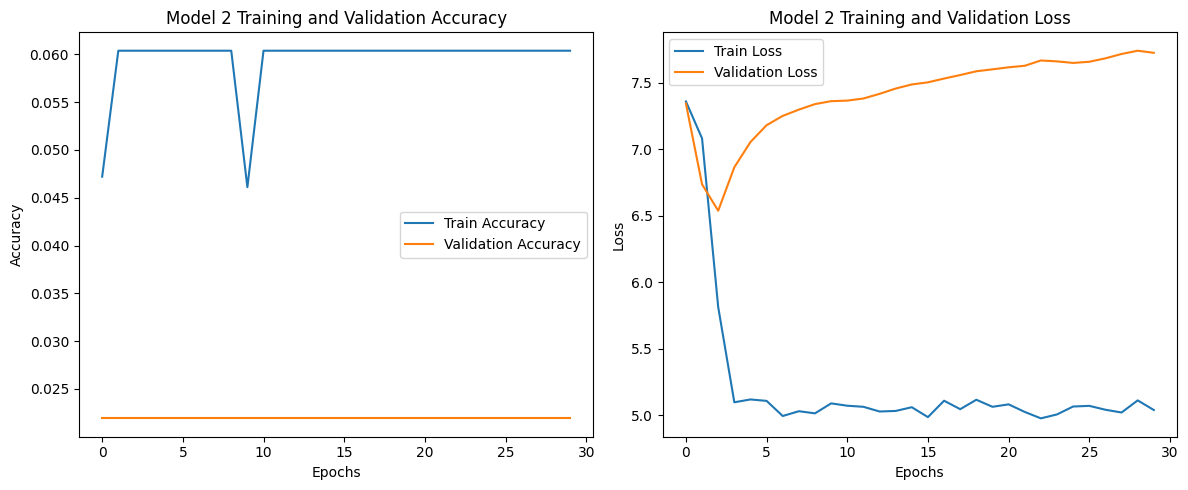

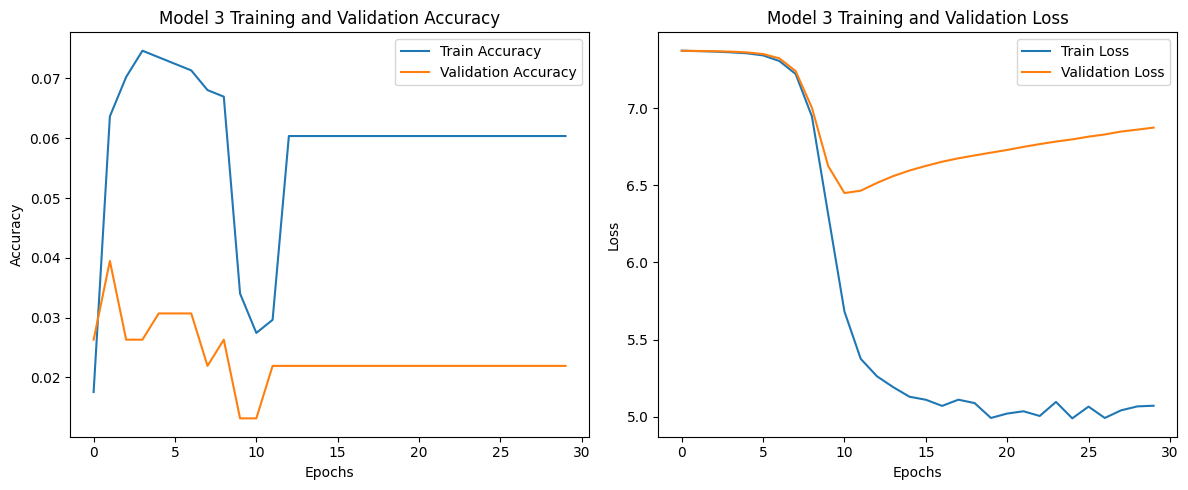

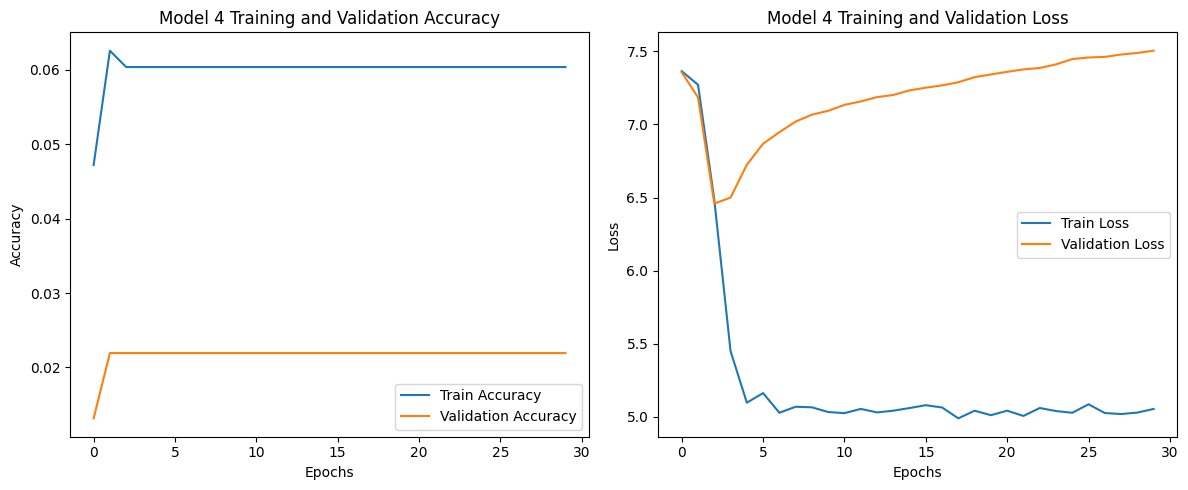

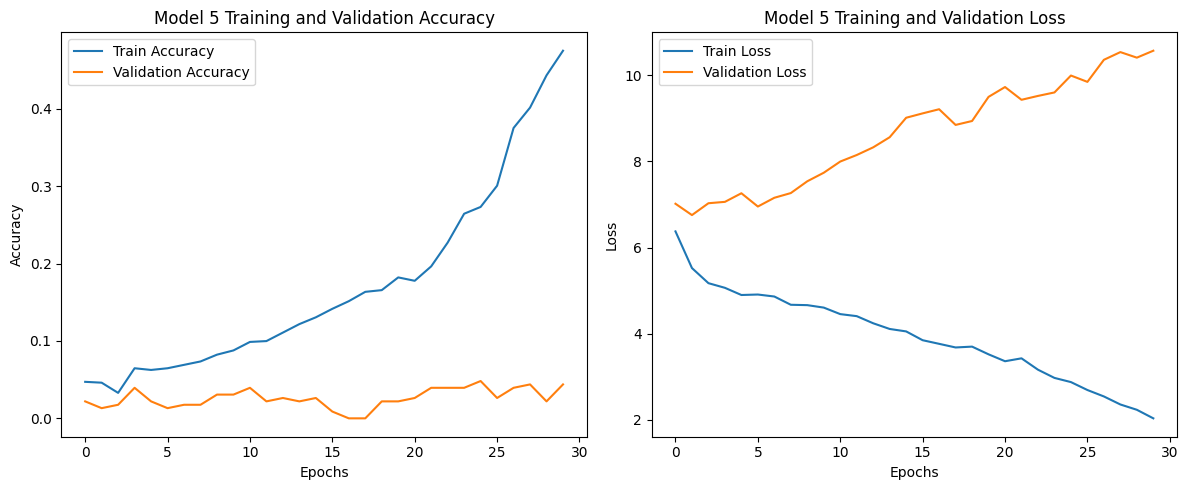

In [9]:
for idx, (model, accuracy, perplexity, loss) in enumerate(results):
    print(f"Model {idx+1} - Accuracy: {accuracy}, Perplexity: {perplexity}, Loss: {loss}")


for idx, history in enumerate(hist_list):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model {idx+1} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model {idx+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
#selecting the best model based on high accuracy and lowest perplexity

best__model = min(results, key = lambda item: (-item[1], item[2])) #negative accuracy for descending order 

best__model[0].save('best_1D_lyrics_generator_model.keras')

# Save the tokenizer using pickle

with open('tokenizer_lyric.pkl', 'wb') as handle:
    pickle.dump(tokenizer_lyric, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# defining a function to generate text with controlled word count

def generate__text(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        # Ensure padding to the exact max_sequence_len that model expects
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        generated_words.append(output_word)
        if len(generated_words) >= min_words and (output_word in [".", "!", "?"] or len(generated_words) == max_words):
            break
    return ' '.join(generated_words)

# Example of generating text with the improved function
print(generate__text("love you every single day", 450, 500, best__model[0], tokenizer_lyric, seq_len))




love you every single day to i'm broken my the you go be lies the pain out my heart the gonna be heart you smile be my the like rest heart you wild be the home the one again my the same air ru young young young my way masks life my my my my my my head you feel alive home alone in the feel to it be my life bed one the said to i'm i'll you was mind in the dark clothes lies a life pretend the same out lies me it home we're young out bed it out my bed masks where mistakes till my where inside it life lies me it real ru young my my life head it life get my my my head get here it feels alone it the feel to it be my mind to i'm of my bed life life heart overwhelmed gonna be the it the same air lies big mistakes be heart touch while lies me it heart it the you she's my heart you gonna ooh you go be my my the one the you was for in heart said yeah oh with me yeah it me yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah yeah ye

In [12]:
def generate__text2(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    word_freq = {word: generated_words.count(word) for word in generated_words}  # Initialize word frequency dictionary

    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        
        # Loop to find the next suitable word that hasn't exceeded the repetition limit
        for probability_index in predicted_probs.argsort()[0][::-1]:  # Iterate through indices of sorted probabilities
            potential_word = tokenizer.index_word[probability_index]
            if word_freq.get(potential_word, 0) < 8:
                output_word = potential_word
                word_freq[potential_word] = word_freq.get(potential_word, 0) + 1
                break

        # If no suitable word found, default to the most probable word
        if output_word == "":
            output_word = tokenizer.index_word[predicted_index]
            word_freq[output_word] = word_freq.get(output_word, 0) + 1

        generated_words.append(output_word)

        # Check if generated enough words and try to end on a punctuation if possible
        if len(generated_words) >= min_words and output_word in [".", "!", "?"]:
            break

    return ' '.join(generated_words[:max_words])

# Example of generating text with the improved function
print(generate__text2("love you every single day", 450, 500, best__model[0], tokenizer_lyric, seq_len))


love you every single day to i'm i'll one you said to i'm locked nothing's go be my the life life heart what gonna am you out of time yeah yeah oh oh oh yeah yeah yeah yeah yeah yeah oh oh oh oh oh best song best song ever up know up know it us it your on love the said to i'm be my the same heart in the same air heart in of my way out thing my my life my my head you out my more the where air lies it life out young mistakes one out get heart overwhelmed the out out lies you it out games young young of get the feel alive me it it the it on said to i'm infinity young young young young young lies feel alive me it with me me me me me me rock you care it's care it's care it's never it's never it's never it's never it's never it's never enough never care care care care care know rock you know i never show rock you know i know i know i know i all night up all night up all night up to night up to night up to night up to night i all night i all your tshirt her i don't don't don't don't ooh with 

In [13]:
! pip install transformers


# Lyrics generation using Transformers

In [39]:
! pip install ipywidgets
! jupyter nbextension enable --py widgetsnbextension  # Only necessary if using Jupyter Notebook (not JupyterLab)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [40]:
!pip uninstall keras  


^C


In [14]:
!pip install --upgrade tensorflow 

In [15]:
import tensorflow as tf


In [16]:
from tensorflow import keras


In [17]:
!pip install --upgrade transformers


In [18]:
!pip install tf-keras

In [19]:
import tensorflow as tf
import transformers

print("TensorFlow Version:", tf.__version__)
print("Transformers Version:", transformers.__version__)


TensorFlow Version: 2.16.1
Transformers Version: 4.41.2


In [20]:
lyrics_df

,Lyrics_clean
1,you're insecure don't know what for
2,you're turnin' heads when you walk through the...
3,don't need makeup to cover up huh
4,bein' the way that you are is enough
5,everyone else in the room can see it
...,...
4121,and i wanna love like you made me feel
4124,oh lord
4126,kiss me where i lay down
4134,when we were eighteen eighteen


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
lyrics_data = lyrics_df.copy()


lyrics = lyrics_data['Lyrics_clean'].dropna().tolist()  # Ensure no NaN values



# split the dataset into training and validation sets
train_texts, val_texts = train_test_split(lyrics, test_size=0.1, random_state=42)


In [23]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

tokenizer_gpt = GPT2Tokenizer.from_pretrained("gpt2")

# Setting pad_token_id to eos_token_id because GPT2 does not have a PAD token
tokenizer_gpt.pad_token = tokenizer_gpt.eos_token

# Tokenize the texts for GPT-2 which expects the format:
train_encode = tokenizer_gpt('\n\n'.join(train_texts), return_tensors='tf', padding=True, truncation=True)
val_encode = tokenizer_gpt('\n\n'.join(val_texts), return_tensors='tf', padding=True, truncation=True)




#model_gpt = TFGPT2LMHeadModel.from_pretrained("gpt2")
#print("Model and tokenizer loaded successfully.")


#### creating TensorFlow Datasets

In [24]:
import tensorflow as tf

# Helper function to create a tf.data.Dataset from our tokenized data
def create_tf_dataset(encodings):
    def gen():
        for i in range(len(encodings.input_ids)):
            yield {'input_ids': encodings.input_ids[i], 'attention_mask': encodings.attention_mask[i]}
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature={
            'input_ids': tf.TensorSpec(shape=(None,), dtype=tf.int32),
            'attention_mask': tf.TensorSpec(shape=(None,), dtype=tf.int32)
        }
    )

# Convert encodings into TensorFlow datasets
train_dataset = create_tf_dataset(train_encode).shuffle(1000).batch(4)  # Adjust batch size as per available computation
val_dataset = create_tf_dataset(val_encode).batch(4)



#### Fine-tuning the Model

In [28]:
!pip uninstall tensorflow-intel


^C


In [57]:
!pip list | findstr tensorflow


tensorflow                   2.16.1
tensorflow-intel             2.16.1
tensorflow-io-gcs-filesystem 0.31.0


In [25]:
!pip install --upgrade tensorflow transformers


In [29]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model
model_gpt = TFGPT2LMHeadModel.from_pretrained('gpt2', pad_token_id=tokenizer_gpt.eos_token_id)

# Define optimizer and compile the model with custom loss
optimizer_tf = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_gpt.compile(optimizer=optimizer_tf, loss=loss)

# Train the model

model_gpt.fit(train_dataset, validation_data=val_dataset, epochs=5)


All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x00000210D342A310>

In [14]:
def generate_lyrics_text(prompt, max_length=500):
    # Encode input context
    input_ids = tokenizer_gpt.encode(prompt, return_tensors='tf')
    # Generate output from the model
    output = model_gpt.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        repetition_penalty=2.5,
        top_p=0.92,
        temperature=0.85,
        do_sample=True,
        top_k=125,
        early_stopping=True
    )
    decode_out = tokenizer_gpt.decode(output[0], skip_special_tokens=True)
    return decode_out

In [15]:
prompt_txt = "Baby, I will love you every single day"
gen_text = generate_lyrics_text(prompt_txt, max_length=500)
print("generated lyrics : " '\n', gen_text)

c:\Users\Ananya\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\generation\configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


generated lyrics : 
 Baby, I will love you every single day.
I don't care if it's in my body or not.. If he was lying to me... He'd say "oh mommy..." and come back with a face full of tears when we were really down on our luck."

 (Piercing the Pecan) Yes! The world is going mad as hell for doing this?! Are YOU joking? You've got nothing but balls about your head while they're trying desperately take away all that joy from their little princesses??????!! Just want some more time off baby boy? It'll be fine without him... Goodnight......Love,,PeaceHoney!!!!


In [ ]:
def generate_text_gpt2(prompt, max_length=500):
    inputs = tokenizer_gp.encode(prompt, return_tensors="tf")
    outputs = model_gpt.generate(inputs, max_length=max_length, num_return_sequences=1)
    text = tokenizer_gp.decode(outputs[0], skip_special_tokens=True)
    return text













""" 
inputs = Input(shape=(input_length,))
    x = Embedding(input_dim=size_vocab, output_dim=embedding_dim)(inputs)
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LSTM(lstm_units)(x)
    outputs = Dense(size_vocab, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


"""


In [12]:
def test_model():
    model = Sequential()
    model.add(Embedding(input_dim=1000, output_dim=50, input_length=10))  # Use example values
    model.add(LSTM(100))
    model.add(Dense(1000, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the model
model = test_model()
model.summary()


ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 10}

In [9]:
def create__model(embedding_dim, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=size_vocab, output_dim=embedding_dim, input_length=seq_len))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dense(size_vocab, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
# Defining a function to create models
def create__model(embedding_dim, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=size_vocab, output_dim=embedding_dim, input_length=seq_len))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dense(size_vocab, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [10]:
# model configuration

models = []
configurations = [
    (50, 100, 0.1, 0.001),
    (100, 150, 0.2, 0.001),
    (150, 200, 0.2, 0.0001),
    (100, 100, 0.3, 0.001),
    (50, 200, 0.1, 0.01)
]


In [11]:
# Training and evaluating the models
res = [] #results
histories = []
for config in configurations:
    model = create__model(*config)
    history = model.fit(X, y, epochs=30, batch_size=128, validation_split=0.2, verbose=2)
    histories.append(history)
    models.append(model)
    loss, accuracy = model.evaluate(X, y, verbose=0)
    perplexity = math.exp(loss) if loss < 300 else float('inf')
    res.append((model, accuracy, perplexity, loss))



ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 10}

In [ ]:
# Preprocess data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Lyrics_clean'])
sequences = tokenizer.texts_to_sequences(data['Lyrics_clean'])
vocab_size = len(tokenizer.word_index) + 1

# Create sequences
seq_length = 10
input_sequences = []
for seq in sequences:
    for i in range(seq_length, len(seq)):
        input_sequence = seq[i-seq_length:i+1]
        input_sequences.append(input_sequence)

input_sequences = pad_sequences(input_sequences, maxlen=seq_length+1, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = to_categorical(y, num_classes=vocab_size)

# Define a function to create models
def create_model(embedding_dim, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

models = []
configurations = [
    (50, 100, 0.1, 0.001),
    (100, 150, 0.2, 0.001),
    (150, 200, 0.2, 0.0001),
    (100, 100, 0.3, 0.001),
    (50, 200, 0.1, 0.01)
]

# Train and evaluate models
results = []
histories = []
for config in configurations:
    model = create_model(*config)
    history = model.fit(X, y, epochs=30, batch_size=128, validation_split=0.2, verbose=2)
    histories.append(history)
    models.append(model)
    loss, accuracy = model.evaluate(X, y, verbose=0)
    perplexity = math.exp(loss) if loss < 300 else float('inf')
    results.append((model, accuracy, perplexity, loss))

# Select the best model based on accuracy or perplexity
best_model = max(results, key=lambda item: item[1])
best_model[0].save('best_lyrics_generator.h5')
print(f"Best Model - Accuracy: {best_model[1]}, Perplexity: {best_model[2]}")

# Save the tokenizer using pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Function to generate text with controlled word count
def generate_text(seed_text, min_words, max_words, model, tokenizer, max_sequence_len):
    generated_words = seed_text.split()
    while len(generated_words) < max_words:
        token_list = tokenizer.texts_to_sequences([' '.join(generated_words)])[-1]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = predicted_probs.argmax(axis=-1)[0]
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        generated_words.append(output_word)
        if len(generated_words) >= min_words and output_word in [".", "!", "?"]:
            break
    return ' '.join(generated_words)

# Example of generating text
print(generate_text("love you every single day", 250, 400, best_model[0], tokenizer, seq_length))

# Plotting results
fig, axes = plt.subplots(len(models), 2, figsize=(10, 18))
for idx, history in enumerate(histories):
    axes[idx, 0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[idx, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[idx, 0].set_title(f'Model {idx+1} Training and Validation Accuracy')
    axes[idx, 0].set_xlabel('Epochs')
    axes[idx, 0].set_ylabel('Accuracy')
    axes[idx, 0].legend()

    axes[idx, 1].plot(history.history['loss'], label='Train Loss')
    axes[idx, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[idx, 1].set_title(f'Model {idx+1} Training and Validation Loss')
    axes[idx, 1].set_xlabel('Epochs')
    axes[idx, 1].set_ylabel('Loss')
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()